In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.insert(0,"../python/rrvf2017/")

In [3]:
from rrvf_data import read_data,show_data,show_data2,show_features, normalize, DataGen

In [4]:
columns,data=read_data("../input/train_test_ext.npy.npz")
len(columns),data.shape

(1, 829, 517) (59, 829, 517)


(67, (829, 517, 67))

In [5]:
gc.collect()

15

In [6]:
#show_data(data,columns, 1,480, None)

In [7]:
#show_data2(data,columns)

# cv

In [8]:
n_reg_lookback=28

In [9]:
def get_index(cols):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [10]:
rawy=data[:,:,get_index(['visitors'])[0]].copy()
rawy.shape

(829, 517)

In [11]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'geo2_visitors_mean', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 'day_of_week_visitors_mean', 'station_count_y2', 'all_count_y5'])
len(lag_cols)

26

In [12]:
def make_ondate_train_test(ondate_cols):
    ondate_train_test=data[:,:,get_index(ondate_cols)].copy()
    ondate_train_test=normalize(ondate_train_test)
    print ondate_train_test.shape
    return ondate_train_test

In [13]:
ondate_cols =array(['const_one', 'visitor_lag91', 'weekday6', 'holiday', 'TMAX']+
                  ['store_nan_week_ratio', 'store_y1_week_ratio', 'store_y2_week_ratio', 'store_y4_week_ratio', 'store_y4_week_ratio'])
ondate_cols =array(['const_one', 'visitor_lag91', 'weekday6', 'holiday', 'TMAX'])
len(ondate_cols)

5

In [14]:
def make_lag_train_test(lag_cols):
    lag_train_test=data[:,:,get_index(lag_cols)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [15]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [16]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session
print K.floatx()

Using TensorFlow backend.


float32


In [17]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
#config.intra_op_parallelism_threads=8
#config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

# time split

In [18]:
import cPickle as pickle
indexes=[pickle.load(open(u)) for  u in ['train_idx_1.pkl','train_idx_2.pkl','train_idx_3.pkl']]

In [19]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "patience":[5],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'mean_squared_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 5})

In [20]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [21]:
from sklearn.metrics import mean_squared_error

In [22]:
def predict_test(self,test_gen):
    X, y, mask,w =test_gen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X
def g(a,test_gen):
    result=predict_test(a,test_gen)
    df=pd.DataFrame({'y':result[2][:,0]})
    df['pred']=result[0][:,0]
    df['dayidx']=result[1][:,1]
    df=df.loc[~df['y'].isnull()]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    display(df2)
    print df2['error2'].mean()
    return  df2['error2'].mean()
def h(self,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=478-39)
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, Xdict)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), 
    return yy_pred, dataidx


In [23]:
reload(rrvf)
import rrvf_data
def _run_once(index, ondate_cols,lag_cols,n_lookforward,n_offset,rawy):
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols)
    lag_train_test = make_lag_train_test(lag_cols)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    lag_input_dim=lag_train_test.shape[-1]
    ondate_input_dim=ondate_train_test.shape[-1]
    print lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)
    backend.clear_session()
    set_session(tf.Session(config=config))   
    a=rrvf.KerasModel("testconv", n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                      ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim, n_offset=n_offset,
                      max_epoch=100, use_output_exp=False,use_dropout=False,model_type="conv",
                      params=parameter)
    a._make_model()
    print a.params
    print a.model.count_params()
    a.fit(train_gen,valid_gen)
    if a.model.abnormal_stop:
        return np.inf,None,None
    test_loss,testy,testpred,testidx=a.eval_datagen_train(test_gen)
    valid_loss,validy,validpred,valididx=a.eval_valid()
    train_loss,trainy,trainpred,trainidx=a.eval_train()
    print 'loss', train_loss,valid_loss,test_loss
    
    g(a,test_gen)
    pred478=h(a,train_gen)
    return valid_loss,(validy,valididx,validpred),(trainy,trainidx,trainpred),(testy,testidx,testpred),pred478



def run_once(index, ondate_cols,lag_cols,n_lookforward,n_offset,rawy):
    while 1:
        ret=_run_once(index, ondate_cols,lag_cols,n_lookforward,n_offset,rawy)
        if ret[0]<1:
            return ret
        else:
            print "bad init,try again."
        

In [24]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [25]:
reload(rrvf)
j=0
validpreds={}
for offset in range(1,2):
    print "\n\n",offset
    _,validpred,trainpred,testpred,pred478=run_once(indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1,rawy=rawy)
    validpreds[offset]=[validpred,trainpred,pred478]
    pickle.dump(validpreds, open('conv_bn_valid{}_preds_test.pkl'.format(j),'wb'))



1
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 191561 records out of 334087 records
valid has 20663 records out of 334087 records
train has 5803 records out of 5803 records
no valid set
1496
0
26 5 (1, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367617
Epoch 1/100
1496/1496 [==============================] - 18s 12ms/step - loss: 0.3138 - total_loss: 0.3138 - reg_loss: 0.3138 - val_loss: 0.2686 - val_total_loss: 0.2686 - val_reg_loss: 0.2686
Epoch 2/100
1496/1496 [==============================] - 17s 11ms/step - loss: 0.2905 - total_loss: 0.2905 - reg_loss: 0.2905 - val_loss: 0.2597 - val_total_loss: 0.2597 - val_reg_loss: 0.2597
Epoch 3/100
1496/1496 [==============================] - 17s 11ms/step - loss: 0.2856 - total_loss: 0.2856 - reg_loss: 0.2856 - val_loss: 0.270

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.816716  0.112394  0.274501    7  2017-04-16
472     2.507290  2.578676 -0.071385  0.261168    1  2017-04-17
473     2.661330  2.645373  0.015957  0.284643    2  2017-04-18
474     2.754815  2.749394  0.005421  0.244469    3  2017-04-19
475     2.713762  2.734983 -0.021222  0.263640    4  2017-04-20
476     2.999000  2.959191  0.039809  0.173810    5  2017-04-21
477     3.075529  3.067174  0.008355  0.201814    6  2017-04-22

0.243435023596
best_epochs [5, 7, 9, 6, 2]
(829, 1) 2.6512388017


In [26]:
round_1pred=np.zeros_like(rawy)

In [27]:
round_1pred[validpred[1][:,0],validpred[1][:,1]]=validpred[2][:,0]
round_1pred[trainpred[1][:,0],trainpred[1][:,1]]=trainpred[2][:,0]
round_1pred[testpred[1][:,0],testpred[1][:,1]]=testpred[2][:,0]

In [28]:
round2_rawy=rawy-0.2*round_1pred

In [29]:
np.nanmean(round2_rawy),np.nanvar(round2_rawy)

(2.3221776, 0.57663387)

In [30]:
for u in [rawy, round2_rawy]:#,round3_rawy,round4_rawy,round5_rawy]:
    u=u[:,:478-7-39]
    print np.nanvar(u), np.nanmean(u), np.isnan(u).sum()

0.646582 2.79734 139088
0.523998 2.25699 139088


In [31]:
reload(rrvf)
j=0
validpreds={}
for offset in range(1,2):
    print "\n\n",offset
    _,validpred,trainpred,testpred,pred478=run_once(indexes[j],ondate_cols,lag_cols,
                                                    n_lookforward=offset,n_offset=offset-1,rawy=round2_rawy)
    validpreds[offset]=[validpred,trainpred,pred478]
    pickle.dump(validpreds, open('conv_bn_valid{}_preds_test.pkl'.format(j),'wb'))



1
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 191561 records out of 334087 records
valid has 20663 records out of 334087 records
train has 5803 records out of 5803 records
no valid set
1496
0
26 5 (1, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367617
Epoch 1/100
1496/1496 [==============================] - 20s 14ms/step - loss: 0.3063 - total_loss: 0.3063 - reg_loss: 0.3063 - val_loss: 0.2694 - val_total_loss: 0.2694 - val_reg_loss: 0.2694
Epoch 2/100
1496/1496 [==============================] - 20s 14ms/step - loss: 0.2856 - total_loss: 0.2856 - reg_loss: 0.2856 - val_loss: 0.2632 - val_total_loss: 0.2632 - val_reg_loss: 0.2632
Epoch 3/100
1496/1496 [==============================] - 20s 13ms/step - loss: 0.2813 - total_loss: 0.2813 - reg_loss: 0.2813 - val_loss: 0.257

y      pred     error    error2  day        date
dayidx                                                         
471     2.365767  2.289000  0.076767  0.266556    7  2017-04-16
472     1.991555  2.083782 -0.092226  0.266508    1  2017-04-17
473     2.132255  2.125141  0.007114  0.282174    2  2017-04-18
474     2.204936  2.219906 -0.014970  0.239567    3  2017-04-19
475     2.166765  2.206247 -0.039482  0.265276    4  2017-04-20
476     2.407161  2.393371  0.013791  0.173673    5  2017-04-21
477     2.462094  2.495573 -0.033479  0.201893    6  2017-04-22

0.242235218648
best_epochs [15, 11, 18, 17, 13]
(829, 1) 2.07450110247


In [32]:
round_2pred=np.zeros_like(rawy)
round_2pred[validpred[1][:,0],validpred[1][:,1]]=validpred[2][:,0]
round_2pred[trainpred[1][:,0],trainpred[1][:,1]]=trainpred[2][:,0]
round_2pred[testpred[1][:,0],testpred[1][:,1]]=testpred[2][:,0]

In [33]:
round3_rawy=round2_rawy-0.2*round_2pred
np.nanvar(round3_rawy)

0.58420354

In [34]:
reload(rrvf)
j=0
validpreds={}
for offset in range(1,2):
    print "\n\n",offset
    _,validpred,trainpred,testpred,pred478=run_once(indexes[j],ondate_cols,lag_cols,
                                                    n_lookforward=offset,n_offset=offset-1,rawy=round3_rawy)
    validpreds[offset]=[validpred,trainpred,pred478]
    pickle.dump(validpreds, open('conv_bn_valid{}_preds_test.pkl'.format(j),'wb'))



1
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 191561 records out of 334087 records
valid has 20663 records out of 334087 records
train has 5803 records out of 5803 records
no valid set
1496
0
26 5 (1, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367617
Epoch 1/100
1496/1496 [==============================] - 18s 12ms/step - loss: 0.2914 - total_loss: 0.2914 - reg_loss: 0.2914 - val_loss: 0.2608 - val_total_loss: 0.2608 - val_reg_loss: 0.2608
Epoch 2/100
1496/1496 [==============================] - 17s 11ms/step - loss: 0.2770 - total_loss: 0.2770 - reg_loss: 0.2770 - val_loss: 0.2567 - val_total_loss: 0.2567 - val_reg_loss: 0.2567
Epoch 3/100
1496/1496 [==============================] - 17s 11ms/step - loss: 0.2753 - total_loss: 0.2753 - reg_loss: 0.2753 - val_loss: 0.256

y      pred     error    error2  day        date
dayidx                                                         
471     1.907967  1.825391  0.082576  0.267649    7  2017-04-16
472     1.574799  1.675473 -0.100674  0.265930    1  2017-04-17
473     1.707227  1.698063  0.009164  0.274440    2  2017-04-18
474     1.760955  1.757749  0.003206  0.236694    3  2017-04-19
475     1.725516  1.735312 -0.009796  0.260392    4  2017-04-20
476     1.928487  1.875525  0.052963  0.176336    5  2017-04-21
477     1.962980  1.944690  0.018290  0.205387    6  2017-04-22

0.240975525457
best_epochs [9, 13, 10, 12, 14]
(829, 1) 1.67707736926


In [35]:
round_3pred=np.zeros_like(rawy)
round_3pred[validpred[1][:,0],validpred[1][:,1]]=validpred[2][:,0]
round_3pred[trainpred[1][:,0],trainpred[1][:,1]]=trainpred[2][:,0]
round_3pred[testpred[1][:,0],testpred[1][:,1]]=testpred[2][:,0]

In [36]:
round4_rawy=round3_rawy-0.2*round_3pred
np.nanvar(round4_rawy)

0.63790572

In [37]:
reload(rrvf)
reload(rrvf_data)

j=0
validpreds={}
for offset in range(1,2):
    print "\n\n",offset
    _,validpred,trainpred,testpred,pred478=run_once(indexes[j],ondate_cols,lag_cols,
                                                    n_lookforward=offset,n_offset=offset-1,rawy=round4_rawy)
    validpreds[offset]=[validpred,trainpred,pred478]
    pickle.dump(validpreds, open('conv_bn_valid{}_preds_test.pkl'.format(j),'wb'))



1
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 191561 records out of 334087 records
valid has 20663 records out of 334087 records
train has 5803 records out of 5803 records
no valid set
1496
0
26 5 (1, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367617
Epoch 1/100
1496/1496 [==============================] - 17s 12ms/step - loss: 0.2832 - total_loss: 0.2832 - reg_loss: 0.2832 - val_loss: 0.2564 - val_total_loss: 0.2564 - val_reg_loss: 0.2564
Epoch 2/100
1496/1496 [==============================] - 17s 11ms/step - loss: 0.2718 - total_loss: 0.2718 - reg_loss: 0.2718 - val_loss: 0.2519 - val_total_loss: 0.2519 - val_reg_loss: 0.2519
Epoch 3/100
1496/1496 [==============================] - 17s 11ms/step - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698 - val_loss: 0.252

y      pred     error    error2  day        date
dayidx                                                         
471     1.542889  1.499871  0.043018  0.266981    7  2017-04-16
472     1.239704  1.348864 -0.109159  0.270573    1  2017-04-17
473     1.367614  1.359932  0.007683  0.279885    2  2017-04-18
474     1.409405  1.429135 -0.019730  0.236864    3  2017-04-19
475     1.378453  1.423056 -0.044603  0.261003    4  2017-04-20
476     1.553382  1.548898  0.004484  0.170700    5  2017-04-21
477     1.574042  1.604295 -0.030253  0.202783    6  2017-04-22

0.241255480975
best_epochs [13, 10, 18, 9, 7]
(829, 1) 1.36493715708


In [86]:
round_4pred=np.zeros_like(rawy)
round_4pred[validpred[1][:,0],validpred[1][:,1]]=validpred[2][:,0]
round_4pred[trainpred[1][:,0],trainpred[1][:,1]]=trainpred[2][:,0]

In [88]:
round5_rawy=round4_rawy-0.2*round_4pred
np.nanvar(round5_rawy)

0.72991049

In [93]:
reload(rrvf)
reload(rrvf_data)
j=0
validpreds={}
for offset in range(1,2):
    print "\n\n",offset
    _,validpred,trainpred,pred478=run_once(indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1,rawy=round5_rawy)
    validpreds[offset]=[validpred,trainpred,pred478]
    pickle.dump(validpreds, open('conv_bn_valid{}_preds.pkl'.format(j),'wb'))



1
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 183214 records out of 334087 records
valid has 19736 records out of 334087 records
train has 5803 records out of 5803 records
no valid set
1431
0
26 10 (1, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1431/1431 [==============================] - 17s 12ms/step - loss: 0.2090 - total_loss: 0.2090 - reg_loss: 0.2090 - val_loss: 0.1682 - val_total_loss: 0.1682 - val_reg_loss: 0.1682
Epoch 2/100
1431/1431 [==============================] - 17s 12ms/step - loss: 0.1841 - total_loss: 0.1841 - reg_loss: 0.1841 - val_loss: 0.1652 - val_total_loss: 0.1652 - val_reg_loss: 0.1652
Epoch 3/100
1431/1431 [==============================] - 17s 12ms/step - loss: 0.1821 - total_loss: 0.1821 - reg_loss: 0.1821 - val_loss: 0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  1.213643  1.715467  3.486418    7  2017-04-16
472     2.507290  1.126994  1.380297  2.313849    1  2017-04-17
473     2.661330  1.149605  1.511725  2.712302    2  2017-04-18
474     2.754815  1.196213  1.558602  2.854795    3  2017-04-19
475     2.713762  1.177138  1.536624  2.769291    4  2017-04-20
476     2.999000  1.253903  1.745097  3.413022    5  2017-04-21
477     3.075529  1.286703  1.788826  3.609322    6  2017-04-22

3.02271420311
best_epochs [10, 9, 15, 6, 8]
(829, 1) 1.16600255178


In [94]:
0.161513886715**0.5

0.4018879031707722

In [89]:
for u in [rawy, round2_rawy,round3_rawy,round4_rawy,round5_rawy]:
    u=u[:,:478-7-39]
    print np.nanvar(u), np.nanmean(u), np.isnan(u).sum()

0.646582 2.79734 139088
0.514456 2.25683 139088
0.445437 1.82206 139088
0.408116 1.47787 139088
0.382503 1.19722 139088


In [49]:
 (round_1pred>0).sum()

334087

In [26]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T[0]
testpreds.shape
    

(829, 39)

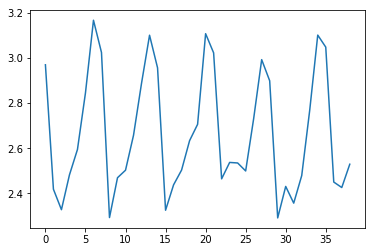

In [27]:
plt.plot(testpreds[129])

In [28]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [29]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              2.140631   
air_0164b9927d20bcc3_2017-04-23              1.282569   
air_0241aa3964b7f861_2017-04-23              2.238569   
air_0328696196e46f18_2017-04-23              2.174855   
air_034a3d5b40d5b1b1_2017-04-23              3.502690   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   7.504798  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   2.605891  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   8.379896  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.800909  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  32.204664

In [30]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [31]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [32]:
submission.to_csv("../submission/2002_lstm_run_1.csv.gz",compression='gzip')